In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F

def visualize_sequence(seq):

    plt.imshow(seq, cmap='cool')
    plt.title('KE')

    plt.show()

## 1. Filling in the Gaps

### a) Constraints of Parameters
The output of the controller is split into each of the different parameters to be used for interacting with the memory. Each parameter is constrained by definition, and can be constrained through functions. Below each slice for each parameter will be called $x$. It is also important to note that each of the parameters must be differentiable.

#### K 
K has no constraints, and thus, is taken as the raw output of the controller.
$$ K \in (-\infty, \infty) $$

#### Beta
Beta must be greater than zero, As such, a $ softplus $ output can be used to ensure the output falls in this range. Softplus is defined as:
$$ \beta = softplus(x) = log(1+\exp(x))$$
$$ \beta \in (0,\infty) $$
#### Interpolation: g 
The g parameter is used to interpolate between the last head state, and the new head state.  This can be achieved by keeping g between 0 and 1. This is done using the sigmoid function.
$$ g = \frac{1}{1+exp(-x)} $$
$$ g \in (,1)$$

#### Shift: s
The s parameters is described by a normal distribution over the possible allowable memory shifts one can obtain using the NTM.  The shift parameter is an $ n $ length array, where $ n $ is the maximum allowable shifts one can have in either one direction or 2 direction (depending on how the convolution is performed). This is discussed in question 2.e.  For now, s is a distribution over the number of shifts one would like to obtain. For example, if one wants to allow a shift one bit backwards, one bit forwards, or none at all then $n = 3$ and an appropriate convolution is performed.  Since s is a probability distribution, one can use the softmax function.

$$ s_i = softmax(x_i) = \frac{e^{x_i}}{\sum_k e^{x_k}} $$ 

#### Sharpening: Gamma

Gamma is used to sharpen the location of access following the shifting process. In order to do this, one can use the following formula, with $\gamma > 1$. To ensure $\gamma > 1$ one can use the softplus function, as before, and add 1.
$$\gamma = 1+ softplus(x) = 1 + log(1+ e^x) $$
$$ \gamma \in [1,\infty)$$ 

#### Erase: $e$

Erase is used to erase sections of the previous memory. The erase vector must be between 0 and 1. This can be achieved through the sigmoid non-linearity.

$$ e = sigmoid(x) = \frac{1}{1+e^{-x}}$$
$$e \in (0,1)$$

#### Add: $a$

The add vector can have any values and is thus the raw value of the controller's output.

$$a = x$$
$$a \in (-\infty, \infty)$$

### b) Diagram of Dependencies

<img src="files/NTM_Flow.jpg">

### 2a) Number of Hyperparameters

For each of the following set ups, we define:
$$m_{inbits} = 9$$
$$m_{memsize} = 100$$
$$n_{cout} = 100$$

#### LSTM

The LSTM has 4 sets of matrices $U$ and $W$. Each of these matrices is size $n_{lstmout} x m_{inbits}$. In this case the LSTM has an input size of $m_{inbits} = 9, and n_{lstmout} = 100$ There is an additional linear transformation transforming the size of the hidden state to the output size, $m_{inbits}-1 = 8$. As such there are:
$$n_{params} = 4*(n_{lstmout}*m_{inbits} + n_{lstmout}^2 + n_{lstmout}) + (n_{lstmout}*(m_{inbits}-1) + m_{inbits}-1) = 44,808$$

#### FC NTM

The fully connected controller has weights size $n_{cout} x m_{in}$ and bias size $n_{cout}$. $m_{in}$ is the sum of bits in, $m_{inbits}$ and $m_{memsize}$.  

The controller thus has:
$$ n_{controller} = n_{cout} x (m_{inbits}+m_{memsize}) + n_{cout} = 11,000$$

Each head has a learnable linear transformation from the size of the controller output to the sum of all head parameters (Beta etc.). The sum of all read head parameters is:
$$ sum_{readparams} = len(K) + len(\beta) + len(g) + len(s) + len(\gamma) = m_{memsize} + 1 + 1 + 3 + 1  = 106$$

Thus the read head has:
$$n_{readhead} = sum_{readparams} + sum_{readparams}*n_{cout} = 10,706$$

For the write head there is are additional erase and add parameters. $a \in \mathbb{R}^{memsize}$ and $e \in \mathbb{R}^{memsize}$.

$$ sum_{writeparams} = len(K) + len(\beta) + len(g) + len(s) + len(\gamma) + len(e) + len(a) = m_{memsize} + 1 + 1 + 3 + 1 + m_{memsize} + m_{memsize} = 306$$

Thus the write head has:

$$n_{writehead} = sum_{writeparams} + sum_{writeparams}*n_{cout} = 30,906$$

Finally there is a transformation from the output of the controller concatenated with the memory read to the final output. This transformation has weights size $(n_{cout} + m_{memsize})*(m_{inbits}-1) = 1600$ and bias size $m_{inbits}-1 = 8$.

Thus the total number of parameters is:
$$n_{params} = n_{controller} + n_{readparams} + n_{writeparams} + (n_{cout} + m_{memsize})*(m_{inbits}-1) + 
m_{inbits}-1 $$
$$n_{params} = 11,000 + 10,706+30,906 + 1600+8 = 54,220$$


#### LSTM NTM
The LSTM NTM differs from the FC NTM only in the controller aspect of the design. The LSTM controller has the same number of parameters as the LSTM model, but without the final transformation. In this case:

$$n_{LSTMcontroller} = 4*(n_{lstmout}*m_{inbits} + n_{lstmout}^2 + n_{lstmout}) = 44,000 $$

Thus the LSTM NTM has:
$$n_{params} = n_{LSTMcontroller} + n_{readhead} + n_{writehead} + (n_{cout} + m_{memsize})*(m_{inbits}-1) + 
m_{inbits}-1 = 87,220 $$


#### Notes:

It's worth noting that the memory itself is not  a learnable parameter.

In [2]:
def dataloader(num_batches, batch_size, sequence_width, min_len, max_len):
    for batch_ind in range(num_batches):
        sequence_len = random.randint(min_len, max_len)
        sequence = np.random.binomial(1, 0.5, (sequence_len, batch_size, sequence_width))
        sequence = Variable(torch.from_numpy(sequence))

        inp = Variable(torch.zeros(sequence_len + 1, batch_size, sequence_width + 1))
        inp[:sequence_len, :, :sequence_width] = sequence
        inp[sequence_len, :, sequence_width] = 1.0
        output = sequence.clone().float()

        yield batch_ind+1, inp.float(), output

In [28]:
REPORTFREQ=10
SAVEFREQ=10
def train_model(model,optimizer,loss_crit,num_epochs):
    mean_losses = []
    mean_accuracies = []
    
    for epoch in range(num_epochs):
        losses = []
        accuracy = []
        dloader = dataloader(num_batches,batch_size,8,1,20)
        for batch_index,x,y in dloader:
            model.hidden = model.init_seq()
            optimizer.zero_grad()
            for i in range(x.shape[0]):
                model.forward(x[i])

            output = Variable(torch.zeros(y.shape))
            for i in range(y.shape[0]):
                output[i] = model.forward()
            acc = evaluate(output,y)

            accuracy.append(acc)
            #print(accuracy[-1])
            loss = loss_crit(output,y)
            loss.backward()
            clip_grads(model)
            optimizer.step()
            losses.append(loss.data[0])
        
        mean_loss =  np.mean(losses)
        mean_accuracy = np.mean(accuracy)
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch+1,mean_loss,mean_accuracy))
        if (epoch%REPORTFREQ==0):
            visualize_sequence(x[:,0,:].data)
            visualize_sequence(torch.round(output[:,0,:]).data)
            
        if (epoch% SAVEFREQ==0):
            model_type = model.ctype
            fname = "./Models/{}-{}-Loss-{}-Accuracy-{}.model".format(model_type,epoch,mean_loss,mean_accuracy)
            torch.save(model.state_dict(),fname)
        mean_losses.append(mean_loss)
        mean_accuracies.append(mean_accuracy)
        
    return mean_losses, mean_accuracies

def evaluate(logits,y):
    preds = torch.round(logits)
    correct =  torch.sum(preds.eq(y).float().data)    
    total = (y.shape[0]*y.shape[1]*y.shape[2])
    accuracy = correct/total
    return accuracy

def evaluate_model(model,seq_lengths,loss_crit,num_sequences):
    mean_accs = []
    mean_losses =[]
    for seq in seq_lengths:
        accuracy=[]
        losses = []
        dloader = dataloader(num_sequences,1,8,seq,seq)
        for batch_index, x, y in dloader:
            model.hidden = model.init_seq()
            for i in range(x.shape[0]):
                model.forward(x[i])
            output = Variable(torch.zeros(y.shape))
            for i in range(y.shape[0]):
                output[i] = model.forward()
            acc = evaluate(output,y)
            accuracy.append(acc)
            loss = loss_crit(output,y)
            losses.append(loss.data[0])
        mean_losses.append(np.mean(losses))
        mean_accs.append(np.mean(accuracy))
    return mean_losses, mean_accs
    
def clip_grads(model):
    parameters = list(filter(lambda x: x.grad is not None, model.parameters()))
    for param in parameters:
        param.grad.data.clamp_(-10, 10)

In [4]:
class LSTM(nn.Module):
    def __init__(self,in_dim, hidden_dim,batch_size = 1,num_bits=8):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim,1)
        self.hidden2label = nn.Linear(hidden_dim, num_bits)
        self.in_size = num_bits+1
        self.batch_size = batch_size
        self.hidden = self.init_hidden()
        self.bits = num_bits
    
    def init_seq(self):
        self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1,self.batch_size,self.hidden_dim))
        c0 = Variable(torch.zeros(1,self.batch_size,self.hidden_dim))
        return (h0, c0)

    def forward(self, x=None):
        if (type(x)==type(None)):
            x = Variable(torch.zeros(self.batch_size,self.bits+1))
        lstm_out,self.hidden = self.lstm(x.unsqueeze(0), self.hidden)
        
        y  = self.hidden2label(lstm_out)
        y = F.sigmoid(y)
        return y
    @property
    def ctype(self):
        return "LSTM"
    
    def num_params(self):
        count = 0
        #Trainable Parameters
        parameters = filter(lambda p: p.requires_grad, self.parameters())
        num_train_params = sum([np.prod(p.size()) for p in parameters])
        print("Model has {} trainable parameters".format(num_train_params))
            

## 2. b) LSTM Hyperparameter Search

In [903]:
batch_size = 1
num_batches=5000
num_epochs = 52
LS = LSTM(9,100,batch_size)

Model has 45208 trainable parameters
None


Epoch: 1, Loss: 0.6912510789632798, Accuracy: 0.5171865829421266


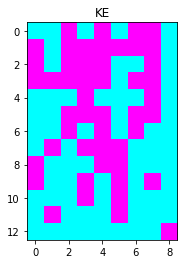

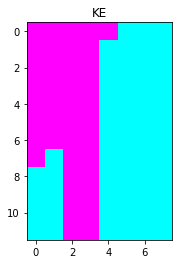

Epoch: 2, Loss: 0.6760694564580917, Accuracy: 0.5855928347151644
Epoch: 3, Loss: 0.6637269157767296, Accuracy: 0.5917438824193952
Epoch: 4, Loss: 0.6562551906704903, Accuracy: 0.5906921363315908
Epoch: 5, Loss: 0.6394160790443421, Accuracy: 0.6076505959952071
Epoch: 6, Loss: 0.62654200142622, Accuracy: 0.6078936264780112
Epoch: 7, Loss: 0.6285598867237568, Accuracy: 0.603778700316926
Epoch: 8, Loss: 0.6164016733765603, Accuracy: 0.6084925740098824
Epoch: 9, Loss: 0.6032798783630132, Accuracy: 0.6116327202714297
Epoch: 10, Loss: 0.6049832292497158, Accuracy: 0.6023269075244502
Epoch: 11, Loss: 0.5837881272509694, Accuracy: 0.6105637677628099


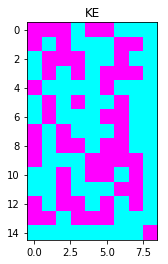

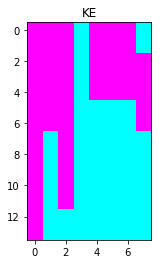

Epoch: 12, Loss: 0.5856856493987143, Accuracy: 0.5998638259702115
Epoch: 13, Loss: 0.5835663464404642, Accuracy: 0.598599630378007
Epoch: 14, Loss: 0.5644221935123205, Accuracy: 0.6130862194199849
Epoch: 15, Loss: 0.5619718980751932, Accuracy: 0.6120636943584022
Epoch: 16, Loss: 0.5425738499639556, Accuracy: 0.6331376929733065
Epoch: 17, Loss: 0.5565367705295794, Accuracy: 0.6278925943917624
Epoch: 18, Loss: 0.5455790183073841, Accuracy: 0.6384104308316382
Epoch: 19, Loss: 0.5469762336302083, Accuracy: 0.6418533572400251
Epoch: 20, Loss: 0.5192795196545776, Accuracy: 0.6634529462625437
Epoch: 21, Loss: 0.5112838319417787, Accuracy: 0.6715525169425517


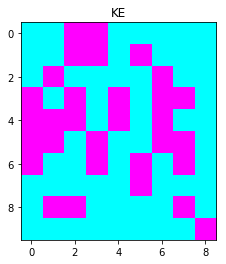

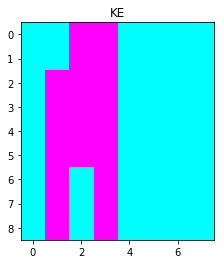

Epoch: 22, Loss: 0.5044552481662249, Accuracy: 0.6771863993634504
Epoch: 23, Loss: 0.5064743147601839, Accuracy: 0.6697091922138749
Epoch: 24, Loss: 0.4911670751557685, Accuracy: 0.6820382983921394
Epoch: 25, Loss: 0.49145064385380827, Accuracy: 0.6759575306938505
Epoch: 26, Loss: 0.4749206906497711, Accuracy: 0.6943424874950902
Epoch: 27, Loss: 0.4934944172948599, Accuracy: 0.6843879585692086
Epoch: 28, Loss: 0.4753403667786042, Accuracy: 0.6973653048523114
Epoch: 29, Loss: 0.4608661160607007, Accuracy: 0.7094207078965497
Epoch: 30, Loss: 0.45210969651743654, Accuracy: 0.7193084729683801
Epoch: 31, Loss: 0.4612291839567915, Accuracy: 0.710899721920881


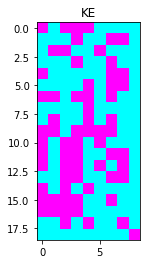

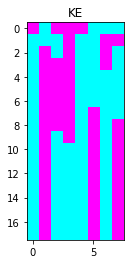

Epoch: 32, Loss: 0.46906577983369063, Accuracy: 0.7079288819571812
Epoch: 33, Loss: 0.45633733602182475, Accuracy: 0.7183815464269991
Epoch: 34, Loss: 0.4392754284544062, Accuracy: 0.7309438991478078
Epoch: 35, Loss: 0.44304552901953864, Accuracy: 0.7262846215693062
Epoch: 36, Loss: 0.437919761382218, Accuracy: 0.7339631474562589
Epoch: 37, Loss: 0.4271700272174312, Accuracy: 0.7384174531404699
Epoch: 38, Loss: 0.4062447259273831, Accuracy: 0.7537212976587395
Epoch: 39, Loss: 0.4270399320390934, Accuracy: 0.7393534181579945
Epoch: 40, Loss: 0.4242526495068596, Accuracy: 0.7424696699993333
Epoch: 41, Loss: 0.428926325531098, Accuracy: 0.7391785756329583


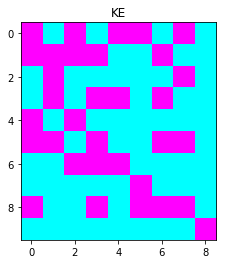

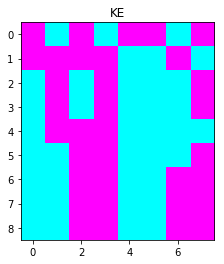

Epoch: 42, Loss: 0.42181683561540195, Accuracy: 0.7429805786104161
Epoch: 43, Loss: 0.4099710160268987, Accuracy: 0.7495298950340166
Epoch: 44, Loss: 0.4155016651692531, Accuracy: 0.749813979987161
Epoch: 45, Loss: 0.40628428144047213, Accuracy: 0.7509418813814325
Epoch: 46, Loss: 0.40269536674886874, Accuracy: 0.7566326051861365
Epoch: 47, Loss: 0.4011961744541113, Accuracy: 0.7569329676934262
Epoch: 48, Loss: 0.40653246037250573, Accuracy: 0.7550116696169328
Epoch: 49, Loss: 0.3973026427671466, Accuracy: 0.7571940148806732
Epoch: 50, Loss: 0.4092555226207278, Accuracy: 0.7479027343356678
Epoch: 51, Loss: 0.3984410539547389, Accuracy: 0.7563821902813388


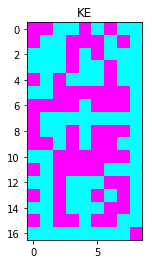

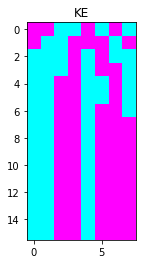

Epoch: 52, Loss: 0.395189332715483, Accuracy: 0.7559651759478482
Epoch: 53, Loss: 0.3684472959680206, Accuracy: 0.7760103979515067
Epoch: 54, Loss: 0.3865952363125034, Accuracy: 0.7621041124477947
Epoch: 55, Loss: 0.37361037960523025, Accuracy: 0.7696037734335239
Epoch: 56, Loss: 0.37089297458471265, Accuracy: 0.7713668921839684
Epoch: 57, Loss: 0.38386287992301915, Accuracy: 0.763404666507598
Epoch: 58, Loss: 0.3779888754276544, Accuracy: 0.764975531028569
Epoch: 59, Loss: 0.36506892046070516, Accuracy: 0.7787723788960439
Epoch: 60, Loss: 0.38044978722025646, Accuracy: 0.765817672833917
Epoch: 61, Loss: 0.3806980761484083, Accuracy: 0.7619662643363688


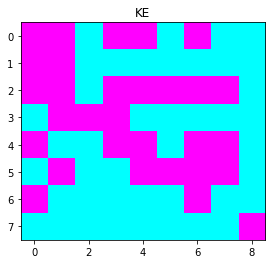

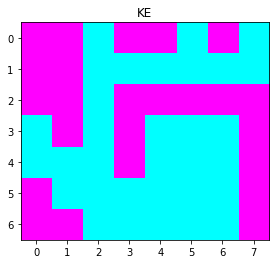

Epoch: 62, Loss: 0.36286103129110187, Accuracy: 0.7764811789098844
Epoch: 63, Loss: 0.376273625431214, Accuracy: 0.76369933345271
Epoch: 64, Loss: 0.3649965158666773, Accuracy: 0.7731422615235213
Epoch: 65, Loss: 0.35494958879758814, Accuracy: 0.7799323587714745
Epoch: 66, Loss: 0.3753227490347708, Accuracy: 0.7632091289536915
Epoch: 67, Loss: 0.35018458621768583, Accuracy: 0.7821656032188056
Epoch: 68, Loss: 0.3476513628591947, Accuracy: 0.7825575361203554
Epoch: 69, Loss: 0.3529251633647782, Accuracy: 0.7771161447545832
Epoch: 70, Loss: 0.33899459259936976, Accuracy: 0.7860042377052342
Epoch: 71, Loss: 0.3432984734915551, Accuracy: 0.7794270255984556


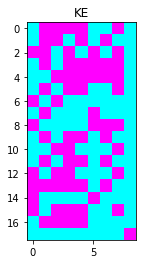

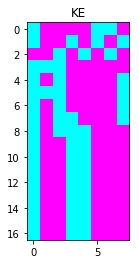

Epoch: 72, Loss: 0.35505605714889044, Accuracy: 0.7794401130936057
Epoch: 73, Loss: 0.33131062989488963, Accuracy: 0.7903771382674343
Epoch: 74, Loss: 0.349774582234646, Accuracy: 0.7758060071647048
Epoch: 75, Loss: 0.3451565505611388, Accuracy: 0.7791348747066916
Epoch: 76, Loss: 0.34924602251255443, Accuracy: 0.7735673318081986
Epoch: 77, Loss: 0.3400060393730118, Accuracy: 0.7791775588554033
Epoch: 78, Loss: 0.34444960640333466, Accuracy: 0.7765612267065151
Epoch: 79, Loss: 0.3379362202338207, Accuracy: 0.7783399324896809
Epoch: 80, Loss: 0.3256346088402088, Accuracy: 0.7893384907264647
Epoch: 81, Loss: 0.3396937334924071, Accuracy: 0.7768959689272286


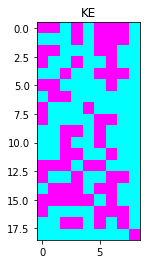

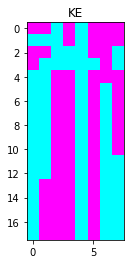

Epoch: 82, Loss: 0.3344800223709117, Accuracy: 0.7800568672018555
Epoch: 83, Loss: 0.33588339352569074, Accuracy: 0.777487221114369
Epoch: 84, Loss: 0.31760123303866566, Accuracy: 0.7895639766161341
Epoch: 85, Loss: 0.33243901696132433, Accuracy: 0.7756803053746648
Epoch: 86, Loss: 0.3323833550695872, Accuracy: 0.7785455237304404
Epoch: 87, Loss: 0.320087243502818, Accuracy: 0.785756962659159
Epoch: 88, Loss: 0.31836856628224247, Accuracy: 0.7880148196606884
Epoch: 89, Loss: 0.3224895576284134, Accuracy: 0.785738180770253
Epoch: 90, Loss: 0.3110203636367812, Accuracy: 0.7906648937835471
Epoch: 91, Loss: 0.3171701502175447, Accuracy: 0.7846312793791606


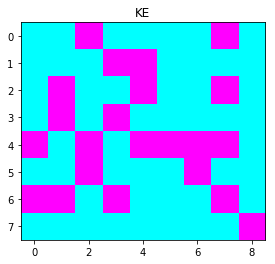

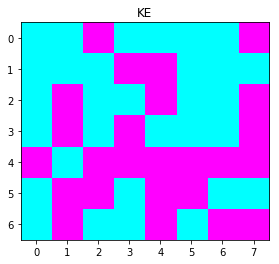

Epoch: 92, Loss: 0.3029766500577709, Accuracy: 0.7964091643714903
Epoch: 93, Loss: 0.3140332394180548, Accuracy: 0.7900103894127888
Epoch: 94, Loss: 0.31170156841950686, Accuracy: 0.7909208233437529
Epoch: 95, Loss: 0.322342131277238, Accuracy: 0.7850163561820875
Epoch: 96, Loss: 0.3323712709224163, Accuracy: 0.7760960549254666
Epoch: 97, Loss: 0.3230458636632386, Accuracy: 0.7793358497303351
Epoch: 98, Loss: 0.3305864804165444, Accuracy: 0.7775961125980573
Epoch: 99, Loss: 0.33863409576116305, Accuracy: 0.7697522012451773
Epoch: 100, Loss: 0.31282716176951614, Accuracy: 0.7903990787087439


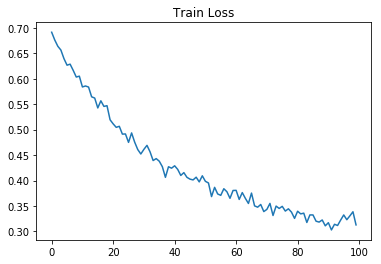

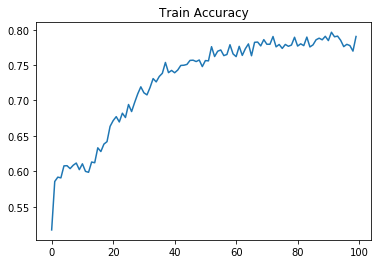

In [11]:
lrs = [1e-4]
momentums = [0.9]
alphas = [0.95]
num_epochs=100
for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            LS = LSTM(9,100,batch_size)
            optimizer = torch.optim.RMSprop(LS.parameters(), lr=lr,momentum=momentum,alpha=alpha)
            loss_crit = torch.nn.BCELoss()
            REPORTFREQ=10
            SAVEFREQ=10
            train_loss, train_accuracy = train_model(LS,optimizer,loss_crit,num_epochs)
            plt.title('Train Loss')
            plt.plot(train_loss)
            plt.show()
            plt.title('Train Accuracy')
            plt.plot(train_accuracy)
            plt.show()
            

#### Hyperparameters:

In the end the chosen LSTM model had the following hyperparameters:

Optimizer: RMSProp

Learning Rate: $10^{-4}$

Momentum: 0.95

Alpha: 0.9

Batch size: 1

Total number of sequences trained on: 260,000



In [5]:
class Memory(nn.Module):
    def __init__(self,N,M,batch_size):
        super(Memory,self).__init__()
        self.N = N
        self.M = M
        self.batch_size = batch_size

        self.register_buffer('mem_bias', Variable(torch.Tensor(N, M)))

        stdev = 1/(np.sqrt(N + M))
        nn.init.uniform(self.mem_bias, -stdev, stdev)

        
    def read(self,w):
        w_read = w.view(self.batch_size,1,-1)
        return torch.matmul(w_read,self.memory).squeeze(1)
    
    def write(self,w,e,a):
        self.old_memory = self.memory
        self.memory = Variable(torch.zeros(self.old_memory.shape))
        self.memory = self.old_memory*(1-torch.matmul(w.unsqueeze(-1),e.unsqueeze(1)))
        self.memory = self.memory + torch.matmul(w.unsqueeze(-1),a.unsqueeze(1))
        
    def reset_mem(self):
        self.memory = self.mem_bias.clone().repeat(self.batch_size, 1, 1)
        #print(self.memory.shape)
class ReadHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(ReadHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_read = nn.Linear(self.in_size, memory.M+1+1+3+1)
        nn.init.xavier_normal(self.linear_read.weight)
        
        
        
        self.param_sizes = [memory.M,1,1,3,1]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
        
    def update_w(self,x):
        k = x[:,:self.param_locations[0]]
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        prev_w = self.w

        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-12,k+1e-12,dim=-1),dim=1)
        wg = g*wc + (1-g)*self.w
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))
        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-12)
        
        self.w = wt
        
    def read_memory(self,x):
        inputs = self.linear_read(x)
        
        self.update_w(inputs)
        read = self.memory.read(self.w)
        
        return read
    
class WriteHead(nn.Module):
    def __init__(self,memory,controller,batch_size):
        super(WriteHead,self).__init__()
        self.memory = memory
        self.batch_size = batch_size
        self.in_size = controller.out_dim
        self.linear_write = nn.Linear(self.in_size, memory.M+1+1+3+1+memory.M + memory.M)
        nn.init.xavier_normal(self.linear_write.weight)
        self.param_sizes = [memory.M,1,1,3,1,memory.M,memory.M,memory.M]
        self.param_locations = [memory.M, memory.M+1, memory.M+2,memory.M+5,memory.M+6, 2*memory.M+6, 3*memory.M+6]
        self.w = None
        
        self.reset_w()
        
    def create_write_params(self,x):
        k = x[:,:self.param_locations[0]].clone()
        B = F.softplus(x[:,self.param_locations[0]:self.param_locations[1]])
        g = F.sigmoid(x[:,self.param_locations[1]:self.param_locations[2]])
        s = F.softmax(x[:,self.param_locations[2]:self.param_locations[3]],dim=1)
        gamma = 1+ F.softplus(x[:,self.param_locations[3]:self.param_locations[4]])
        e = F.sigmoid(x[:,self.param_locations[4]:self.param_locations[5]])
        a = x[:,self.param_locations[5]:self.param_locations[6]]
        
        k = k.contiguous().view(self.batch_size,1,-1)
        wc = F.softmax(B*F.cosine_similarity(self.memory.memory+1e-12,k+1e-12,dim=-1),dim=1)
        wg = g*wc + (1-g)*self.w
        
        #circular_conv
        wc = Variable(torch.zeros(wg.shape))

        for batch in range(batch_size):
            w_batch = wg[batch]
            circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
            wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
            
        #Sharpen
        wt = (wc**gamma)/(torch.sum(wc**gamma,dim=1).view(-1,1)+1e-12)
        self.w = wt
        return wt,e,a
    def reset_w(self):
        self.w = Variable(torch.zeros(self.memory.batch_size,self.memory.N))
    
    def write_memory(self,x):
        inputs = self.linear_write(x)
        w, e, a = self.create_write_params(inputs)
        
        self.memory.write(w,e,a)
        
class FFController(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(FFController,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear_control = nn.Linear(in_dim,out_dim)
    
    def forward(self,x):
        
        a1 = self.linear_control(x)
        #print(np.isnan(np.sum(a1.data[0].numpy())))
        return a1
    @property
    def ctype(self):
        return 'FC'
    



In [6]:
class FCNTM(nn.Module):
    def __init__(self,N,M,input_size,output_size,batch_size):
        super(FCNTM,self).__init__()
        self.memory = Memory(N,M,batch_size)
        self.controller = FFController(input_size+M,100)
        self.readHead = ReadHead(self.memory,self.controller,batch_size)        
        self.writeHead = WriteHead(self.memory,self.controller,batch_size)
        self.prev_read = Variable(torch.zeros(batch_size,M))
        self.batch_size = batch_size
        self.in_size = input_size
        self.LinearOut = nn.Linear(100+M,output_size)
    
    def forward(self, x=None):
        if x is None:
            batch_size = self.batch_size
            x = Variable(torch.zeros(batch_size,self.in_size))
        inputs = torch.cat((x,self.prev_read),dim=1)
        c_output = self.controller.forward(inputs)
        
        
        
        self.prev_read = self.readHead.read_memory(c_output)
        self.writeHead.write_memory(c_output)
        inp2output = torch.cat((c_output,self.prev_read),dim=1)
        output = F.sigmoid(self.LinearOut(inp2output))

        return output
    
    def init_seq(self):
        self.readHead.reset_w()
        self.writeHead.reset_w()
        self.memory.reset_mem()
        self.prev_read = Variable(torch.zeros(self.batch_size,M))
    @property
    def ctype(self):
        return "FC_NTM"

### 2b) Fully Connected NTM HyperParameter Search

Epoch: 1, Loss: 0.6926710206270218, Accuracy: 0.5087635674342427


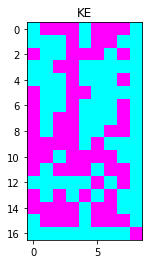

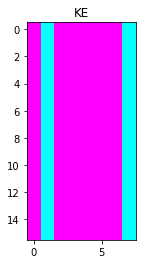

Epoch: 2, Loss: 0.6759785350561142, Accuracy: 0.5839097479403981
Epoch: 3, Loss: 0.6279786162376404, Accuracy: 0.6548105834589387
Epoch: 4, Loss: 0.6206036424934864, Accuracy: 0.6448648063237072
Epoch: 5, Loss: 0.5602182562351227, Accuracy: 0.6966659103785362
Epoch: 6, Loss: 0.27175374384596945, Accuracy: 0.8933260108055
Epoch: 7, Loss: 0.03279019646445522, Accuracy: 0.9937097587719298
Epoch: 8, Loss: 0.000520432197901755, Accuracy: 0.9999375
Epoch: 9, Loss: 5.784517855167337e-05, Accuracy: 1.0
Epoch: 10, Loss: 5.791926504719602e-07, Accuracy: 1.0
Epoch: 11, Loss: 0.00021841120069942331, Accuracy: 0.9999107142857142


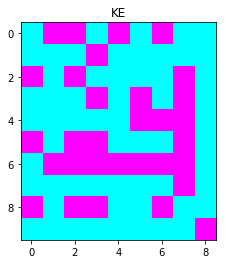

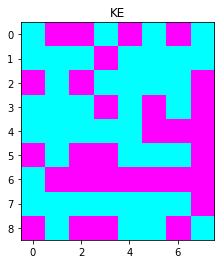

Epoch: 12, Loss: 2.4556725299107462e-08, Accuracy: 1.0
Epoch: 13, Loss: 0.0027058946416941942, Accuracy: 0.9998611111111111
Epoch: 14, Loss: 8.971574389608772e-10, Accuracy: 1.0
Epoch: 15, Loss: 2.3102540243607333e-10, Accuracy: 1.0
Epoch: 16, Loss: 2.711363853323198e-10, Accuracy: 1.0
Epoch: 17, Loss: 1.5138372279560955e-10, Accuracy: 1.0
Epoch: 18, Loss: 8.871106235101151e-11, Accuracy: 1.0
Epoch: 19, Loss: 9.06993832486963e-11, Accuracy: 1.0
Epoch: 20, Loss: 8.864111232650615e-11, Accuracy: 1.0
Epoch: 21, Loss: 7.824168174463963e-11, Accuracy: 1.0


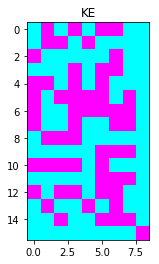

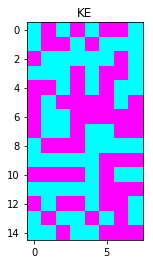

Epoch: 22, Loss: 6.198985006061264e-11, Accuracy: 1.0
Epoch: 23, Loss: 3.894034598700587e-11, Accuracy: 1.0
Epoch: 24, Loss: 7.41105892595106e-11, Accuracy: 1.0
Epoch: 25, Loss: 3.881050578352987e-11, Accuracy: 1.0
Epoch: 26, Loss: 4.177880202522479e-11, Accuracy: 1.0
Epoch: 27, Loss: 4.111195174745508e-11, Accuracy: 1.0
Epoch: 28, Loss: 2.954048985732028e-11, Accuracy: 1.0
Epoch: 29, Loss: 5.84029536853303e-11, Accuracy: 1.0
Epoch: 30, Loss: 2.975982973054981e-11, Accuracy: 1.0
Epoch: 31, Loss: 2.5654425528444142e-11, Accuracy: 1.0


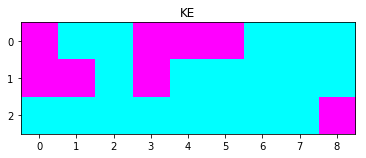

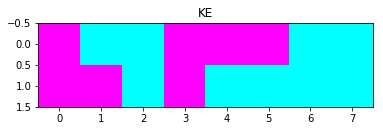

Epoch: 32, Loss: 4.678730395680283e-11, Accuracy: 1.0


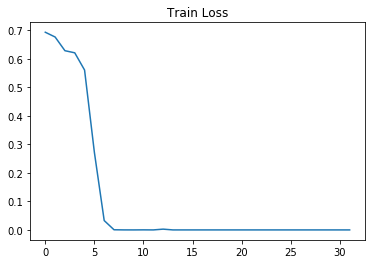

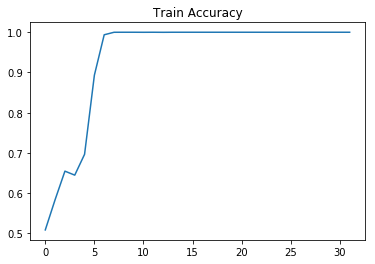

In [10]:
batch_size = 1
num_batches=500
num_epochs = 32
Ms = [100]
N = 128
SAVEFREQ=5
lrs = [5e-5]
momentums = [0.9]
alphas = [0.95]

for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            for M in Ms:
                fc_ntm = FCNTM(N,M,8+1,8,batch_size)
                optimizer = torch.optim.RMSprop(fc_ntm.parameters(), lr=lr,momentum=momentum,alpha=alpha)
                loss_crit = torch.nn.BCELoss()
                train_loss, train_accuracy = train_model(fc_ntm,optimizer,loss_crit,num_epochs)
                plt.plot(train_loss)
                plt.title('Train Loss')
                plt.show()
                plt.title('Train Accuracy')
                plt.plot(train_accuracy)
                plt.show()

#### Hyperparameters
In the end the chosen FC-NTM model had the following hyperparameters:

Optimizer: RMSProp

Learning Rate: $5^{-5}$

Momentum: 0.95

Alpha: 0.9

Batch size: 1

Total number of sequences trained on: 16,000

Memory size: 100

Total number of memory locations: 128

In [7]:
class LSTMController(nn.Module):
    def __init__(self,in_dim, out_dim):
        super(LSTMController,self).__init__()
        self.lstm = nn.LSTM(in_dim, 100,1)
        self.batch_size = batch_size
        self.init_hidden()
        self.out_dim = out_dim
    
    def init_seq(self):
        self.init_hidden()

    def init_hidden(self):
        h0 = Variable(torch.zeros(1,self.batch_size,100))
        c0 = Variable(torch.zeros(1,self.batch_size,100))
        self.hidden = (h0, c0)

    def forward(self, x=None):
        lstm_out,self.hidden = self.lstm(x.unsqueeze(0), self.hidden)
        return lstm_out.squeeze(0)
    
    @property
    def ctype(self):
        return 'LSTM'

In [8]:
class LSTMNTM(nn.Module):
    def __init__(self,N,M,input_size,output_size,batch_size):
        super(LSTMNTM,self).__init__()
        self.memory = Memory(N,M,batch_size)
        self.controller = LSTMController(input_size+M,100)
        self.readHead = ReadHead(self.memory,self.controller,batch_size)        
        self.writeHead = WriteHead(self.memory,self.controller,batch_size)
        self.prev_read = Variable(torch.zeros(batch_size,M))
        self.batch_size = batch_size
        self.in_size = input_size
        self.LinearOut = nn.Linear(100+M,output_size)
    
    def forward(self, x=None):
        if x is None:
            batch_size = self.batch_size
            x = Variable(torch.zeros(batch_size,self.in_size))
        inputs = torch.cat((x,self.prev_read),dim=1)
        c_output = self.controller.forward(inputs)
        
        
        
        self.prev_read = self.readHead.read_memory(c_output)
        self.writeHead.write_memory(c_output)
        inp2output = torch.cat((c_output,self.prev_read),dim=1)
        output = F.sigmoid(self.LinearOut(inp2output))

        return output
    
    def init_seq(self):
        self.readHead.reset_w()
        self.writeHead.reset_w()
        self.memory.reset_mem()
        self.prev_read = Variable(torch.zeros(self.batch_size,M))
        if self.controller.ctype == 'LSTM':
            self.controller.init_hidden()
            
    @property
    def ctype(self):
        return "LSTM_NTM"

### 2b) LSTM-NTM Hyperparameter Search

Epoch: 1, Loss: 0.6904273006916046, Accuracy: 0.53216425837879


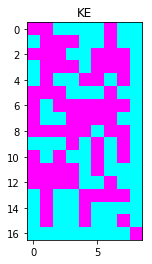

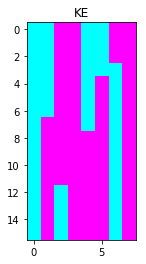

Epoch: 2, Loss: 0.6783517118692398, Accuracy: 0.5755428984994194
Epoch: 3, Loss: 0.6618122538924217, Accuracy: 0.5970859612588134
Epoch: 4, Loss: 0.6513980062007904, Accuracy: 0.6001501473468481
Epoch: 5, Loss: 0.636208851993084, Accuracy: 0.612054138564394
Epoch: 6, Loss: 0.6301894603669643, Accuracy: 0.6072442566066114
Epoch: 7, Loss: 0.6118731262981891, Accuracy: 0.6194296789747061
Epoch: 8, Loss: 0.6020881111621856, Accuracy: 0.6203836530761551
Epoch: 9, Loss: 0.6040157735347748, Accuracy: 0.6153201122997659
Epoch: 10, Loss: 0.579555243741721, Accuracy: 0.6239174219592757
Epoch: 11, Loss: 0.5884370324462652, Accuracy: 0.616421061754508


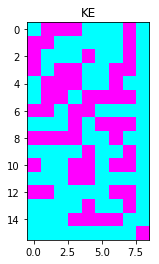

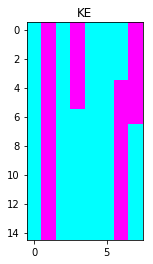

Epoch: 12, Loss: 0.5667805356215686, Accuracy: 0.6271795836301641
Epoch: 13, Loss: 0.5724848501365631, Accuracy: 0.6253147107504209
Epoch: 14, Loss: 0.5599596237549558, Accuracy: 0.6379078185381011
Epoch: 15, Loss: 0.5621860922179185, Accuracy: 0.6439332280829765
Epoch: 16, Loss: 0.5421908117262647, Accuracy: 0.6582648565637148
Epoch: 17, Loss: 0.5401656394668389, Accuracy: 0.6657847529437797
Epoch: 18, Loss: 0.5159366395096294, Accuracy: 0.685475144264705
Epoch: 19, Loss: 0.5079974039375084, Accuracy: 0.6940695647736765
Epoch: 20, Loss: 0.31886369371251205, Accuracy: 0.8379956183167967
Epoch: 21, Loss: 0.06630940846726298, Accuracy: 0.98394176444041


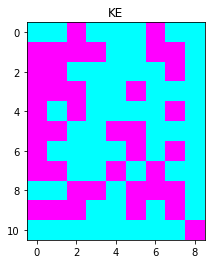

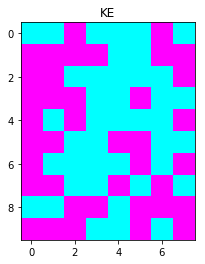

Epoch: 22, Loss: 0.009253651190025266, Accuracy: 0.9989709383753502
Epoch: 23, Loss: 0.0003622595509245912, Accuracy: 0.9999318181818182
Epoch: 24, Loss: 2.2409612213401432e-05, Accuracy: 1.0
Epoch: 25, Loss: 0.006970206474556711, Accuracy: 0.9990789473684211
Epoch: 26, Loss: 5.121669586991562e-07, Accuracy: 1.0
Epoch: 27, Loss: 4.59480119947564e-08, Accuracy: 1.0
Epoch: 28, Loss: 0.011258011566022928, Accuracy: 0.9991625000000001
Epoch: 29, Loss: 2.0942012032426625e-08, Accuracy: 1.0
Epoch: 30, Loss: 4.144727109772761e-09, Accuracy: 1.0
Epoch: 31, Loss: 4.569234725849275e-09, Accuracy: 1.0


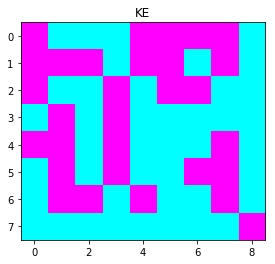

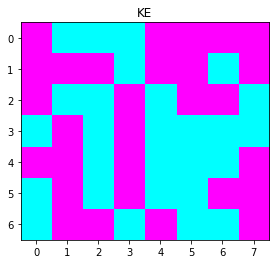

Epoch: 32, Loss: 2.3507930687546863e-09, Accuracy: 1.0
Epoch: 33, Loss: 8.38500284114016e-10, Accuracy: 1.0
Epoch: 34, Loss: 5.05951303268401e-10, Accuracy: 1.0
Epoch: 35, Loss: 4.996602456699279e-10, Accuracy: 1.0
Epoch: 36, Loss: 7.099857154910412e-09, Accuracy: 1.0
Epoch: 37, Loss: 1.4851309537758894e-09, Accuracy: 1.0
Epoch: 38, Loss: 4.921683119454845e-10, Accuracy: 1.0
Epoch: 39, Loss: 2.5062409176809797e-10, Accuracy: 1.0
Epoch: 40, Loss: 2.443286425055091e-10, Accuracy: 1.0
Epoch: 41, Loss: 4.757949149045149e-10, Accuracy: 1.0


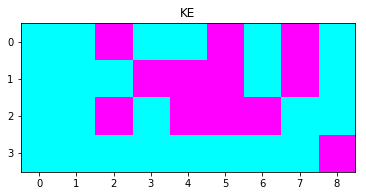

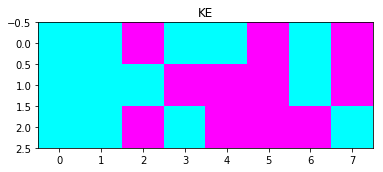

Epoch: 42, Loss: 1.874372268957647e-10, Accuracy: 1.0
Epoch: 43, Loss: 1.7399002956181714e-10, Accuracy: 1.0
Epoch: 44, Loss: 2.0490490758567208e-10, Accuracy: 1.0
Epoch: 45, Loss: 1.7181837451093508e-10, Accuracy: 1.0
Epoch: 46, Loss: 2.1293907218446554e-10, Accuracy: 1.0
Epoch: 47, Loss: 1.24282248860786e-10, Accuracy: 1.0
Epoch: 48, Loss: 1.0210210814169153e-10, Accuracy: 1.0
Epoch: 49, Loss: 0.0013232689670366726, Accuracy: 0.9999375
Epoch: 50, Loss: 0.01655438666241182, Accuracy: 0.9989874999999999
Epoch: 51, Loss: 1.8400742996003276e-08, Accuracy: 1.0


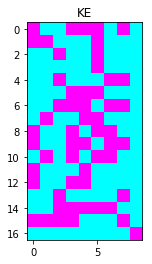

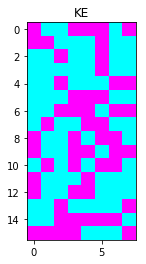

Epoch: 52, Loss: 4.014988666508137e-10, Accuracy: 1.0
Epoch: 53, Loss: 2.009593526195938e-10, Accuracy: 1.0
Epoch: 54, Loss: 2.2755340239782374e-10, Accuracy: 1.0
Epoch: 55, Loss: 1.9623467400445468e-10, Accuracy: 1.0
Epoch: 56, Loss: 1.1323669373811303e-10, Accuracy: 1.0
Epoch: 57, Loss: 9.848087019308227e-11, Accuracy: 1.0
Epoch: 58, Loss: 1.328124529574137e-10, Accuracy: 1.0
Epoch: 59, Loss: 8.488412412809703e-11, Accuracy: 1.0
Epoch: 60, Loss: 7.207559727268617e-11, Accuracy: 1.0
Epoch: 61, Loss: 8.265007823450577e-11, Accuracy: 1.0


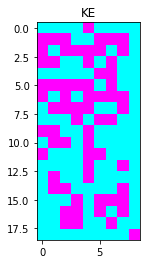

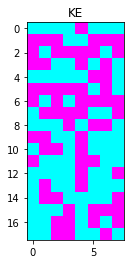

Epoch: 62, Loss: 6.986799671525697e-11, Accuracy: 1.0
Epoch: 63, Loss: 7.150177906613958e-11, Accuracy: 1.0
Epoch: 64, Loss: 1.0375217546361969e-10, Accuracy: 1.0
Epoch: 65, Loss: 6.062071942266201e-11, Accuracy: 1.0
Epoch: 66, Loss: 8.920327628360141e-11, Accuracy: 1.0
Epoch: 67, Loss: 6.203038255132007e-11, Accuracy: 1.0
Epoch: 68, Loss: 6.145754082986094e-11, Accuracy: 1.0
Epoch: 69, Loss: 4.8538816853436336e-11, Accuracy: 1.0
Epoch: 70, Loss: 5.883938630524581e-11, Accuracy: 1.0
Epoch: 71, Loss: 4.370402061272148e-11, Accuracy: 1.0


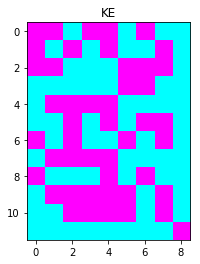

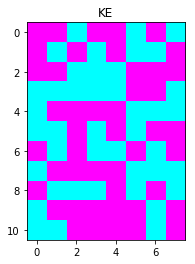

Epoch: 72, Loss: 4.32693884870757e-11, Accuracy: 1.0
Epoch: 73, Loss: 5.674577702467678e-11, Accuracy: 1.0
Epoch: 74, Loss: 5.4822036067128825e-11, Accuracy: 1.0
Epoch: 75, Loss: 8.049123764123506e-11, Accuracy: 1.0
Epoch: 76, Loss: 5.583183357275195e-11, Accuracy: 1.0
Epoch: 77, Loss: 4.462152581393049e-11, Accuracy: 1.0
Epoch: 78, Loss: 3.97867891602623e-11, Accuracy: 1.0
Epoch: 79, Loss: 8.643199836378366e-11, Accuracy: 1.0
Epoch: 80, Loss: 4.940301712261664e-11, Accuracy: 1.0
Epoch: 81, Loss: 3.904610817942607e-11, Accuracy: 1.0


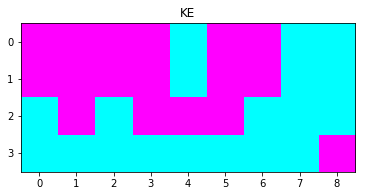

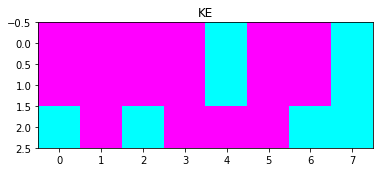

Epoch: 82, Loss: 5.5246119802792445e-11, Accuracy: 1.0
Epoch: 83, Loss: 4.324185520936173e-11, Accuracy: 1.0
Epoch: 84, Loss: 4.142053514589951e-11, Accuracy: 1.0
Epoch: 85, Loss: 9.106931981271716e-11, Accuracy: 1.0
Epoch: 86, Loss: 3.6031737747356215e-11, Accuracy: 1.0
Epoch: 87, Loss: 2.885275614628512e-11, Accuracy: 1.0
Epoch: 88, Loss: 4.951687839057847e-11, Accuracy: 1.0
Epoch: 89, Loss: 3.918645245397151e-11, Accuracy: 1.0
Epoch: 90, Loss: 3.863565919764393e-11, Accuracy: 1.0
Epoch: 91, Loss: 3.274431098558269e-11, Accuracy: 1.0


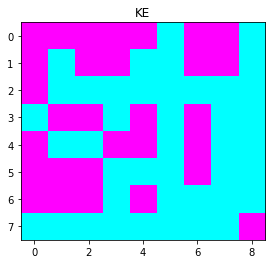

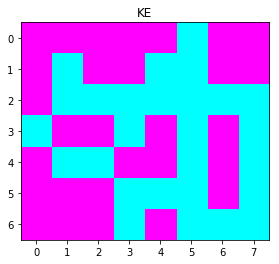

Epoch: 92, Loss: 3.539394827636671e-11, Accuracy: 1.0
Epoch: 93, Loss: 3.196979753425702e-11, Accuracy: 1.0
Epoch: 94, Loss: 3.17624639517645e-11, Accuracy: 1.0
Epoch: 95, Loss: 3.2438311767010836e-11, Accuracy: 1.0
Epoch: 96, Loss: 2.7994732753353156e-11, Accuracy: 1.0
Epoch: 97, Loss: 5.343709438425425e-11, Accuracy: 1.0
Epoch: 98, Loss: 4.327216684854671e-11, Accuracy: 1.0
Epoch: 99, Loss: 2.2590903722688654e-11, Accuracy: 1.0
Epoch: 100, Loss: 7.574337333371624e-11, Accuracy: 1.0


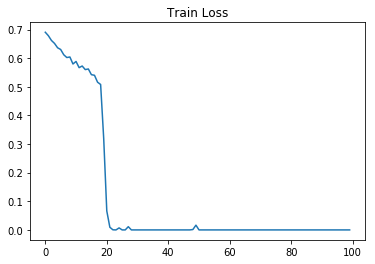

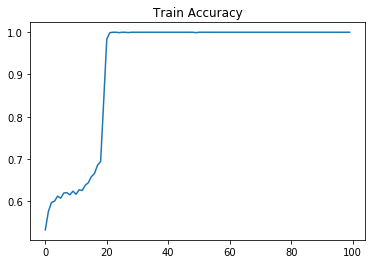

In [9]:
batch_size = 1
num_batches=500
num_epochs = 100
Ms = [100]
N = 128

lrs = [1e-4]
momentums = [0.9]
alphas = [0.95]

for lr in lrs:
    for momentum in momentums:
        for alpha in alphas:
            for M in Ms:
                lstm_ntm = LSTMNTM(N,M,8+1,8,batch_size)
                optimizer = torch.optim.RMSprop(lstm_ntm.parameters(), lr=lr,momentum=momentum,alpha=alpha)
                loss_crit = torch.nn.BCELoss()
                train_loss, train_accuracy = train_model(lstm_ntm,optimizer,loss_crit,num_epochs)
                plt.title('Train Loss')
                plt.plot(train_loss)
                plt.show()
                plt.title('Train Accuracy')
                plt.plot(train_accuracy)
                plt.show()


#### Hyperparameters

In the end the chosen LSTM model had the following hyperparameters:

Optimizer: RMSProp

Learning Rate: $10^{-4}$

Momentum: 0.95

Alpha: 0.9

Batch size: 1

Total number of sequences trained on: 50,000

Memory Size: 100

Number of Memory locations: 128

### 2c) Generalization to Longer Sequences
Below I will test longer sequences for each of the best models created so far. 

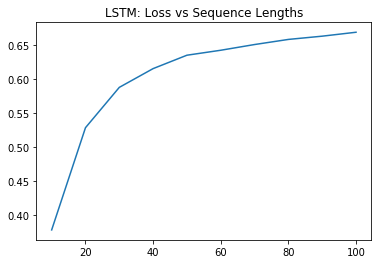

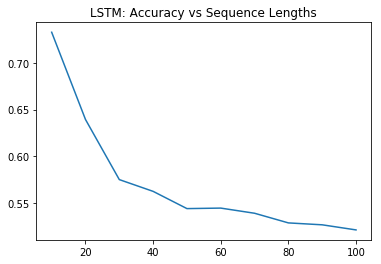

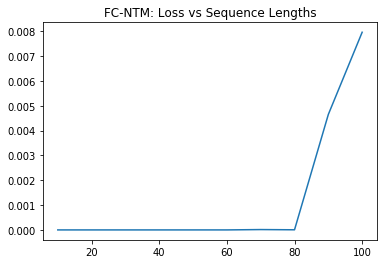

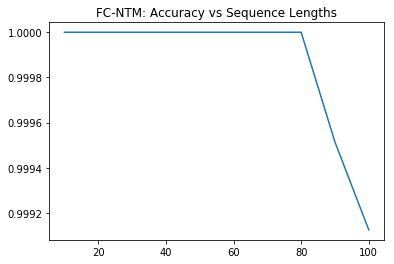

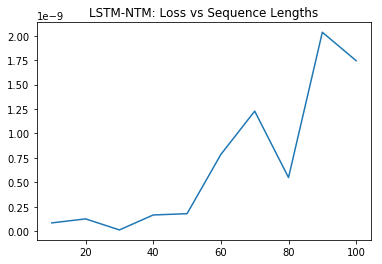

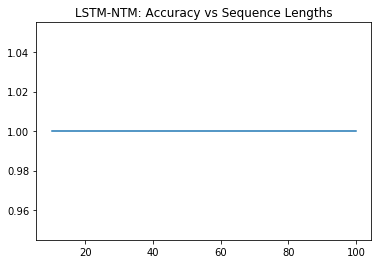

In [36]:
sequence_lengths = [10,20,30,40,50,60,70,80,90,100]
loss_crit = nn.BCELoss()

lstm_losses, lstm_accs = evaluate_model(LS,sequence_lengths,loss_crit,20)

plt.plot(sequence_lengths,lstm_losses)
plt.title('LSTM: Loss vs Sequence Lengths')
plt.show()
plt.plot(sequence_lengths,lstm_accs)
plt.title('LSTM: Accuracy vs Sequence Lengths')
plt.show()

fcntm_losses, fcntm_accs = evaluate_model(fc_ntm, sequence_lengths,loss_crit,20)
plt.plot(sequence_lengths,fcntm_losses)
plt.title('FC-NTM: Loss vs Sequence Lengths')
plt.show()
plt.plot(sequence_lengths,fcntm_accs)
plt.title('FC-NTM: Accuracy vs Sequence Lengths')
plt.show()

lstmntm_losses, lstmntm_accs = evaluate_model(lstm_ntm, sequence_lengths,loss_crit,20)
plt.plot(sequence_lengths,lstmntm_losses)
plt.title('LSTM-NTM: Loss vs Sequence Lengths')
plt.show()
plt.plot(sequence_lengths,lstmntm_accs)
plt.title('LSTM-NTM: Accuracy vs Sequence Lengths')
plt.show()

The LSTM was expected to gradually perform worse as the length of the sequence was increased. Since the LSTM doesn't learn 'algorithmically' it instead learns how to deal with sequences of shorter lengths.  Once dealing with lenghths that are much longer than it's training the LSTM is dealing with uncharted territory and begins to output sequences almost at random.

NTM's were expected to generalize well on the task.  Since the models can learn an algorithm, one would expect the NTM to continue to use the same algorithm after being trained on smaller sequence lengths, even on larger sequence lengths. This appears to be the case, the LSTM Controller NTM made zero mistakes on the larger sequences, and maintained a very minimal loss during it's tests on larger sequences. 

Simialarly the FC Controller NTM maintained 0 loss until sequence length reached roughly 80, at which point a small number of mistakes were made. It is important to note that the accuracy on the total number of bits remained very high. 

### 2d) Visualizing the Read and Write Heads

LSTM NTM


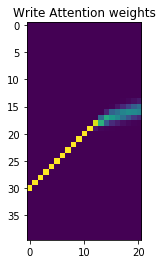

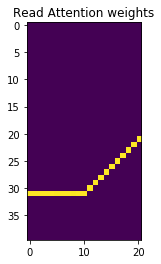

Fully Connected NTM


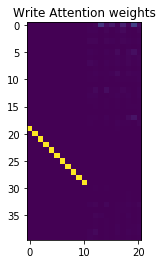

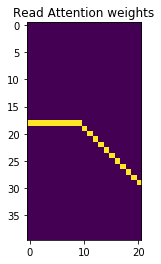

In [63]:
def visualize_heads(model,seq,num_sequences):
    dloader = dataloader(num_sequences,1,8,seq,seq)
    read_attention = []
    write_attention = []
    for batch_index, x, y in dloader:
        model.hidden = model.init_seq()
        for i in range(x.shape[0]):
            model.forward(x[i])
            read_attention.append(model.readHead.w.data[0].numpy())
            write_attention.append(model.writeHead.w.data[0].numpy())
        output = Variable(torch.zeros(y.shape))
        for i in range(y.shape[0]):
            output[i] = model.forward()
            read_attention.append(model.readHead.w.data[0].numpy())
            write_attention.append(model.writeHead.w.data[0].numpy())
            
    write_image = np.array(write_attention)
    read_image = np.array(read_attention)
    return read_image, write_image
print("LSTM NTM")
read_image, write_image = visualize_heads(lstm_ntm,10,1)
plt.imshow(write_image[:,:40].T)
plt.title('Write Attention weights')
plt.show()
plt.imshow(read_image[:,:40].T)
plt.title('Read Attention weights')
plt.show()

print("Fully Connected NTM")
read_image, write_image = visualize_heads(fc_ntm,10,1)
plt.imshow(write_image[:,40:80].T)
plt.title('Write Attention weights')
plt.show()
plt.imshow(read_image[:,40:80].T)
plt.title('Read Attention weights')
plt.show()

One expected to see the write vector shifting one location over in memory as each sequence was put in, and once all writes were complete the read attention was expected to go across the same locations in the same order. Which is in fact what we see here. It is worth noting that the starting location in memory is not the 0th location but appears to be some random starting location within memory.

Note that the full attention vectors are not shown, and only the sections in order to offer a better view of each vector.  In each case it is clear that the read attention is focussed at a location one shift prior to the starting write location until all writes have finished. Once the NTM has written each input sequence into the memory, the read attention focusses on each location in memory in the same order as written, to retrieve the written data.

Once all important data has been written the two NTM's shown each have a general lack of focus in the write attention. Although the LSTM remains more focussed on the last location of writing, indicated by the brighter blue (which is still far away from the very strongly weighted yellow.

### 2.e) Understanding the Shift Operator

The shift operator is used to shift the focus of the memory by some number of locations.  It can be noted that the shift operator operates with modulo N where N is the number of locations available in the memory. The circular convolution allows for an implementation of the shift. First consider a shift vector $s \in \mathbb{R}^m$, first assume a shift operation that can go in either direction. The amount of shifts that can occur in each direction is $\lfloor{\frac{m}{2}}\rfloor$, assuming m is odd (since once should also consider the possibility of no shift). In order to perform the shift, one pads the weight with the other end of the array (thus making a circular convolution). For example given a weight vector of length n and elements $w_i$.  The padded weight vector becomes:
$$w_{padded} = [w_{n-\lfloor{\frac{m}{2}}\rfloor}, w_{n-\lfloor{\frac{m}{2}}\rfloor+1}, w_{n-\lfloor{\frac{m}{2}}\rfloor+2},...,w_{n-1}, w_n, w_0, w_1, ... w_n, w_{0},w_{1},...,w_{0+\lfloor{\frac{m}{2}}\rfloor-1},w_{0+\lfloor{\frac{m}{2}}\rfloor}]$$.

This new padded vector is convolved with the shift vector. The shift vector is a probability distribution across the range of shifts defined, in this case from $-\lfloor \frac{m}{2} \rfloor$ to $\lfloor \frac{m}{2} \rfloor$. If the probability is centered around a specific shift, the output vector will be shifted that many bits over.

Formally, say $s = [0,0,...,1]$ then:
$$w_{padded} * s = [w_{\lfloor \frac{m}{2} \rfloor},w_{\lfloor \frac{m}{2} \rfloor+1},...,w_n,w_0,...,w_{\lfloor \frac{m}{2} \rfloor-1}]$$

Thus the input vector w has been shifted $\lfloor \frac{m}{2} \rfloor$ to the left. (This assumes no kernel flipping in the convolution.)

In the following code, wg[i] is the interpolated weights for the ith batch, which are about the be shifted by the convolution. s[i] is the shift vector for the ith batch in the input. And wc[i] is the shifted(but not sharpened) weight vector for the ith batch.

The code for a shift in 2 directions, with a maximum shift of 1 in either direction, is shown below:
```
wc = Variable(torch.zeros(wg.shape))
for batch in range(batch_size):
    w_batch = wg[batch]
    circ_pad_w = torch.cat((w_batch[-1],w_batch,w_batch[0]))
    wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
```

Note how the circular padding is added on both sides.  If one would instead like to make shifts only possible to the right (in this case one can shift 0, 1 or 2 to the right) one would add padding only on side of the inital weight matrix, as shown below:

```
wc = Variable(torch.zeros(wg.shape))
for batch in range(batch_size):
    w_batch = wg[batch]
    circ_pad_w = torch.cat((w_batch[-2],w_batch[-1],w_batch))
    wc[batch] = F.conv1d(circ_pad_w.view(1,1,-1),s[batch].view(1,1,-1)).view(-1)
```

In order to force shifting only in the opposite direction, one would add padding only on the other side.